In [70]:
%%capture
!pip install -r requirements.txt

In [1]:
from datasets import load_dataset
from transformers import AutoImageProcessor


# Inputs from the user
DATASET_NAME = "cppe-5"
MODEL_NAME = "facebook/detr-resnet-50"
IMAGE_COL = "image"
OBJECTS_COL = "objects"
LABEL_COL = "category"
# Bounding box coordinates, COCO format
BBOX_COL = "bbox"
LOG_MODEL_MLFLOW = True
LOG_DATA_MLFLOW = True

# Load the dataset and the model's image processor 
ds = load_dataset(DATASET_NAME)
image_processor = AutoImageProcessor.from_pretrained(MODEL_NAME)

Found cached dataset cppe-5 (/Users/benepstein/.cache/huggingface/datasets/cppe-5/default/1.0.0/dd60c7c8210a67663b06108fb9e23c70acb98e2d3a4f3636f429509b19b74989)


  0%|          | 0/2 [00:00<?, ?it/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [2]:
# Helpers: Determine the split names. Train/test split if doesn't already exist
from PIL.Image import Image as PIL_Image
from datasets import Dataset

# If the dataset dict only has 1 key, we want to split it into train/test
if len(ds.keys()) == 1:
    key = next(iter(ds.keys()))
    ds = ds[key]

# If we have a dataset, we want to create a dict with train/test
if isinstance(ds, Dataset):
    ds = ds.train_test_split(test_size=0.2, stratify_by_column=LABEL_COL)
    

splits = list(ds.keys())
train_split = "train" if "train" in splits else "training"
eval_split = next(split for split in splits if split != train_split)


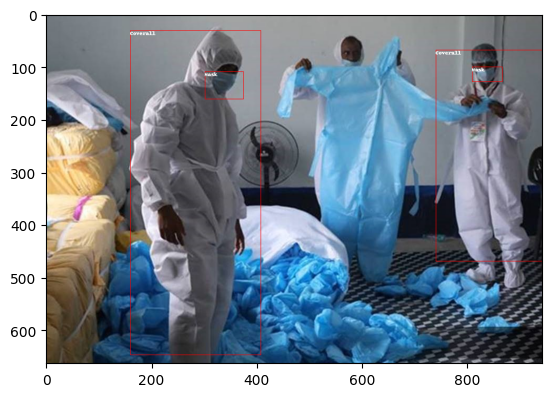

In [3]:
import numpy as np
import os
from PIL import Image, ImageDraw
from matplotlib.pyplot import imshow


# Draw and image and its annotations. Visual validation
image = ds[train_split][0][IMAGE_COL]
annotations = ds[train_split][0][OBJECTS_COL]
draw = ImageDraw.Draw(image)

categories = ds[train_split].features[OBJECTS_COL].feature[LABEL_COL].names

id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

# Draw the boxes over the image
for box, class_idx in zip(annotations[BBOX_COL], annotations[LABEL_COL]):
    # COCO Format: xmin, ymin, width, height
    x, y, w, h = box
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")

    

imshow(image)

# We need to apply augmentations to our images in order to train

### We need to augment the images and format the annotations. See this guide for more details on your model and dataset
https://huggingface.co/docs/datasets/object_detection

In [4]:
import albumentations
import numpy as np
import torch

transform_width = 480
transform_height = 480
transform = albumentations.Compose(
    [
        albumentations.Resize(transform_width, transform_height),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=[LABEL_COL]),
)

In [5]:
from typing import List, Dict

# Structure annotations to format: {'image_id': int, 'annotations': List[Dict]}
def formatted_anns(image_id: int, category: Dict, area: List[float], bbox: List[float]) -> List[Dict]:
    annotations = []
    for i in range(len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": bbox[i],
        }
        annotations.append(new_ann)

    return annotations

# transforming a batch
def transform_aug_ann(examples: Dict[str, List]):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples[IMAGE_COL], examples[OBJECTS_COL]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects[BBOX_COL], category=objects[LABEL_COL])

        area.append(objects["area"])
        images.append(out[IMAGE_COL])
        bboxes.append(out["bboxes"])
        categories.append(out[LABEL_COL])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")


# Use with_transform so these transformations happen on-the-fly rather than all at once
ds[train_split] = ds[train_split].with_transform(transform_aug_ann)

# View one sample
ds[train_split][15]


{'pixel_values': tensor([[[ 1.0159,  1.0159,  1.0159,  ..., -1.3473, -1.3473, -1.3473],
          [ 1.0159,  1.0159,  1.0159,  ..., -1.3473, -1.3473, -1.3473],
          [ 1.0159,  1.0159,  1.0159,  ..., -1.3302, -1.3302, -1.3302],
          ...,
          [-1.0048, -1.0048, -1.0048,  ..., -1.3644, -1.3644, -1.3644],
          [-0.9877, -0.9877, -0.9877,  ..., -1.3644, -1.3473, -1.3473],
          [-0.9877, -0.9877, -0.9877,  ..., -1.3644, -1.3473, -1.3473]],
 
         [[ 1.3782,  1.3782,  1.3782,  ..., -1.1954, -1.1954, -1.1954],
          [ 1.3782,  1.3782,  1.3782,  ..., -1.1954, -1.1954, -1.1954],
          [ 1.3782,  1.3782,  1.3782,  ..., -1.1779, -1.1779, -1.1779],
          ...,
          [-0.7752, -0.7752, -0.7752,  ..., -1.2129, -1.2129, -1.2129],
          [-0.7577, -0.7577, -0.7577,  ..., -1.2129, -1.1954, -1.1954],
          [-0.7577, -0.7577, -0.7577,  ..., -1.2129, -1.1954, -1.1954]],
 
         [[ 1.5071,  1.5071,  1.5071,  ..., -1.0027, -1.0027, -1.0027],
          [ 

## Post-augmentation validation

After augmentations, it may be possible for certain boxes to no longer be valid. In this simple validation, we ensure that all bounding boxes post-augmentation are still valid. That is, the boundaries of the boxes fall within the size of the image. Invalid boxes (otherwise known as "runaway boxes") have their entire image removed from the training set.

In [6]:
from tqdm.auto import tqdm

for split in ds.keys():
    remove_idx = set()
    for i in tqdm(range(len(ds[split]))):
        try:
            ds[train_split][i]
        except ValueError:
            remove_idx.add(i)
            
    keep = [i for i in range(len(ds[split])) if i not in remove_idx]
    print(f"{len(remove_idx)} Samples removed from {split}")
    ds[split] = ds[split].select(keep)

  0%|          | 0/1000 [00:00<?, ?it/s]

3 Samples removed from train


  0%|          | 0/29 [00:00<?, ?it/s]

0 Samples removed from test


In [16]:
# Create a collate function to batch images together. 
# Pad images (which are now pixel_values) to the largest image in a batch, 
# and create a corresponding pixel_mask to indicate which pixels are real (1) and which are padding (0).
from typing import List, Dict, Any

def collate_fn(batch: List[Dict[str, Any]]) -> Dict[str, Any]:
    """Create a collate function to batch images together. 
    
    Pad images (which are now pixel_values) to the largest image in a batch, 
    and create a corresponding pixel_mask to indicate which pixels are real 
    (1) and which are padding (0).
    """
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    result = {}
    result["pixel_values"] = encoding["pixel_values"]
    result["pixel_mask"] = encoding["pixel_mask"]
    result["labels"] = labels
    return result

In [17]:
# Training
from transformers import AutoModelForObjectDetection, TrainingArguments, Trainer
import mlflow.transformers


mlflow.transformers.autolog(
    log_input_examples=True, 
    log_model_signatures=True, 
    log_models=True, 
    log_datasets=True
)


model = AutoModelForObjectDetection.from_pretrained(
    MODEL_NAME,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)


mlflow_run_name = "run1"             # Taken from the user

training_args = TrainingArguments(
    output_dir=mlflow_run_name,
    per_device_train_batch_size=8,  # User Input, use this default
    num_train_epochs=10,            # User Input, use this default
    fp16=True,                      # User Input, use this default (warning when setting False that memory usage will be large)
    save_steps=200,                 # User Input, use this default
    logging_steps=50,               # User Input, use this default
    learning_rate=1e-5,             # User Input, use this default
    weight_decay=1e-4,              # User Input, use this default
    save_total_limit=2,             # User Input, use this default
    remove_unused_columns=False,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=ds[train_split],
    tokenizer=image_processor,
    eval_dataset=ds[eval_split],
)

trainer.train()



Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/benepstein/Documents/GitHub/domino-dca-notebooks/.venv/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
This method is deprecated and will be removed in v4.27.0. Please use pad instead.


Step,Training Loss
50,3.357700
100,2.766300


TrainOutput(global_step=125, training_loss=3.00493017578125, metrics={'train_runtime': 1982.0098, 'train_samples_per_second': 0.503, 'train_steps_per_second': 0.063, 'total_flos': 4.7647056109824e+17, 'train_loss': 3.00493017578125, 'epoch': 1.0})

In [18]:
# Log the dataset and model to mlflow
run_id = mlflow.last_active_run().info.run_id
with mlflow.start_run(run_id=run_id):
    if LOG_MODEL_MLFLOW:
        model_config = {
            "model": trainer.model,
            "image_processor": trainer.tokenizer
        }
        mlflow.transformers.log_model(model_config, artifact_path="model")
    if LOG_DATA_MLFLOW:
        for split in ds.keys():
            data = mlflow.data.from_huggingface(ds[split])
            mlflow.log_input(data, context=split)
    

2023/07/02 16:32:51 WARNING mlflow.transformers: This model is unable to be used for pyfunc prediction because the model is not a language-based model and requires a complex input type that is currently not supported. The pyfunc flavor will not be added to the Model.
2023/07/02 16:32:57 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/2q/xy9rl8zn00b9_3ync0yk3jm40000gn/T/tmpdal9tv1i/model, flavor: transformers), fall back to return ['transformers==4.28.1', 'torch==2.0.1', 'torchvision==0.15.2', 'accelerate==0.20.3']. Set logging level to DEBUG to see the full traceback.
2023/07/02 16:32:57 WARNING mlflow.data.huggingface_dataset: Failed to infer schema for Hugging Face dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/07/02 16:32:58 WARNING mlflow.data.huggingface_dataset